In [9]:
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from astroai.tools.utils import set_wcs

figsize = (10, 10)
histsize = (8, 8)
fs = 16

fov = 2.5
binning = 200
pixelsize = (2 * fov) / binning
point_ref = (binning / 2) + (pixelsize / 2)
radius_pix = 0.2/pixelsize

# random IRF

In [58]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# data
zenith = 'random'  # 'z20'
table = 'cleaner_5sgm_expIRFrandom.npy'
path = f'/home/dipiano/E4/irf_{zenith}/crab/'
dataset = join(path, table)

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
    gammatable = join(path, table.replace('.pickle', '_gammapy.txt'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))
    gammatable = join(path, table.replace('.npy', '_gammapy.txt'))
    

print(f"Classes: {ds.keys()}\n")
print(f"NOISY dataset size: {len(ds['DS1'])}")
print(f"CLEAN dataset size: {len(ds['DS2'])}")

ds['DS1'][0].shape, ds['DS2'][0].shape

Classes: dict_keys(['DS1', 'DS2', 'normalisation'])

NOISY dataset size: 5000
CLEAN dataset size: 5000


((200, 200), (200, 200))

In [59]:
from astroai.tools.utils import split_noisy_dataset

train_noisy, train_clean, test_noisy, test_clean = split_noisy_dataset(ds, split=80, reshape=True, binning=200)

print(f"Train clean: {train_clean.shape}")
print(f"Train noisy: {train_noisy.shape}")
print(f"\nTest clean: {test_clean.shape}")
print(f"Test labenoicyls: {test_noisy.shape}")

Train clean: (4000, 200, 200, 1)
Train noisy: (4000, 200, 200, 1)

Test clean: (1000, 200, 200, 1)
Test labenoicyls: (1000, 200, 200, 1)


In [60]:
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
infodata.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
15000,crab_00001,1,0,100,100,57.265654,30.447065,57.253328,30.454269,0.012838,North_z40_S_0.5h_LST,2.5,7.322825
15001,crab_00002,2,0,100,100,98.177801,40.950640,98.016897,41.081760,0.178695,North_z60_N_50h_LST,2.5,6.762409
15002,crab_00003,3,0,100,100,76.984211,-66.348920,78.358890,-67.138246,0.957894,North_z40_N_5h_LST,2.5,7.029939
15003,crab_00004,4,0,100,100,125.495725,-44.424075,126.479118,-43.608941,1.079135,North_z40_5h_LST,2.5,7.074566
15004,crab_00005,5,0,100,100,214.162576,42.736282,215.790559,43.357500,1.342109,North_z20_5h_LST,2.5,7.087336


In [61]:
import tensorflow as tf

savename = 'cleaner_5sgm_filter12_expRAND' 
model = tf.keras.models.load_model(f'../models/cnn_cleaner/{savename}.keras')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 12)      60        
                                                                 
 average_pooling2d (AverageP  (None, 100, 100, 12)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 12)      588       
                                                                 
 average_pooling2d_1 (Averag  (None, 50, 50, 12)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 12)        588   

In [62]:
predictions = model.predict(test_noisy)

32/32 [==============================] - 1s 35ms/step


In [63]:
loss = model.evaluate(test_noisy, test_clean, verbose=2)

history = np.load(f'../models/cnn_cleaner/{savename}_history.npy', allow_pickle='TRUE').item()
history.keys()

32/32 - 1s - loss: 0.2366 - 1s/epoch - 38ms/step


dict_keys(['loss', 'val_loss'])

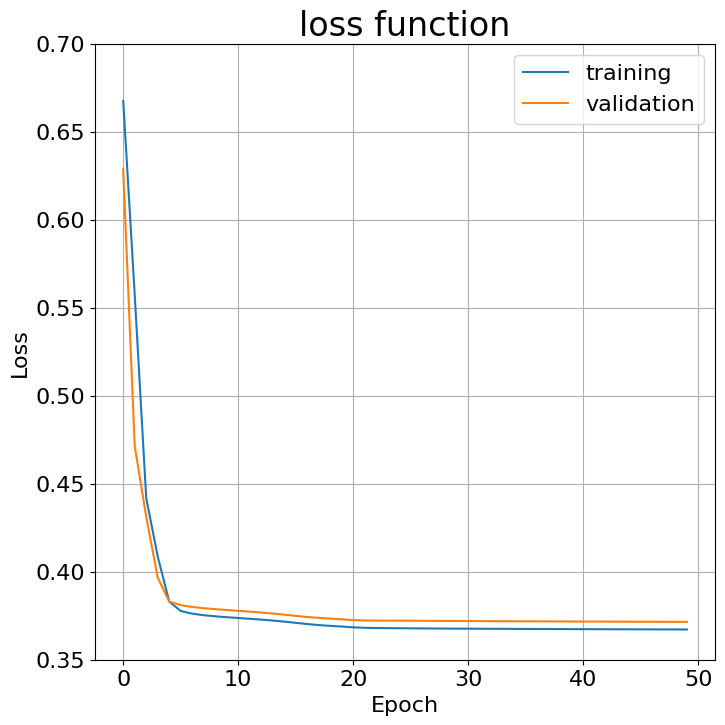

In [64]:
fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)
ax.plot(history['loss'], label='training')
ax.plot(history['val_loss'], label = 'validation')
ax.set_xlabel('Epoch', fontsize=fs)
ax.set_ylabel('Loss', fontsize=fs)
ax.set_title('loss function', fontsize=fs*1.5)
ax.set_ylim([0.35,0.7])
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/talk_rand_loss.png')

In [65]:
residuals = {'STD': [], 'CNN': []}
for noisy, clean, pred in zip(test_noisy, test_clean, predictions):
    residuals['STD'].append(noisy - clean)
    residuals['CNN'].append(noisy - pred)
    
sum_residual = {'STD': [], 'CNN': []}
for std, cnn in zip(residuals['STD'], residuals['CNN']):
    sum_residual['STD'].append(np.sum(std))
    sum_residual['CNN'].append(np.sum(cnn))

sum_cleaned = {'STD': [], 'CNN': []}
for std, cnn in zip(test_clean, predictions):
    sum_cleaned['STD'].append(np.sum(std))
    sum_cleaned['CNN'].append(np.sum(cnn))
    
sum_original_and_diff = {'NOISY': [], 'DIFF': []}
for orig, std, cnn in zip(test_noisy, residuals['STD'], residuals['CNN']):
    sum_original_and_diff['NOISY'].append(np.sum(orig))
    sum_original_and_diff['DIFF'].append(np.sum(std - cnn))

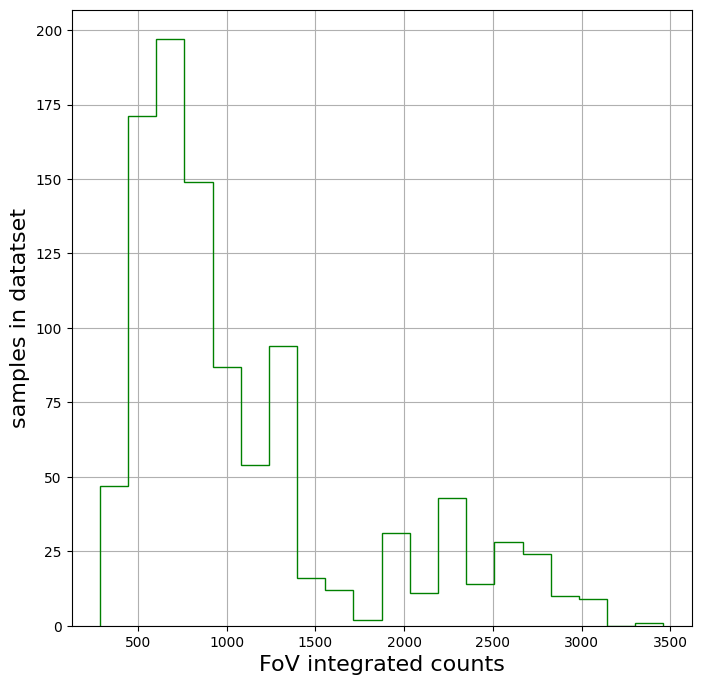

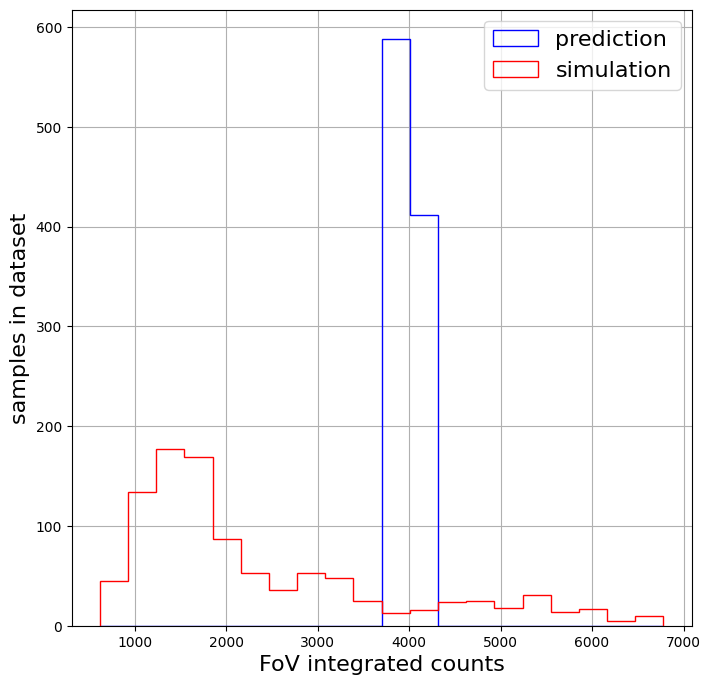

In [66]:
colors = ['red', 'blue']

# original hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = sum_original_and_diff['NOISY']
#ax.set_title('simulations (noisy)', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color='green')
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in datatset', fontsize=fs)
ax.set_xlabel('FoV integrated counts', fontsize=fs)
ax.grid() 
fig.savefig(f'img/talk_rand_noisy_counts.png')
plt.show()

# cumulative counts hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_cleaned['STD'], sum_cleaned['CNN'])
#ax.set_title('simulations vs predictions (clean)', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color=colors, label=['simulation', 'prediction'])
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('FoV integrated counts', fontsize=fs)
ax.legend(fontsize=fs)
ax.grid()

fig.savefig(f'img/talk_rand_clean_counts.png')
plt.show()

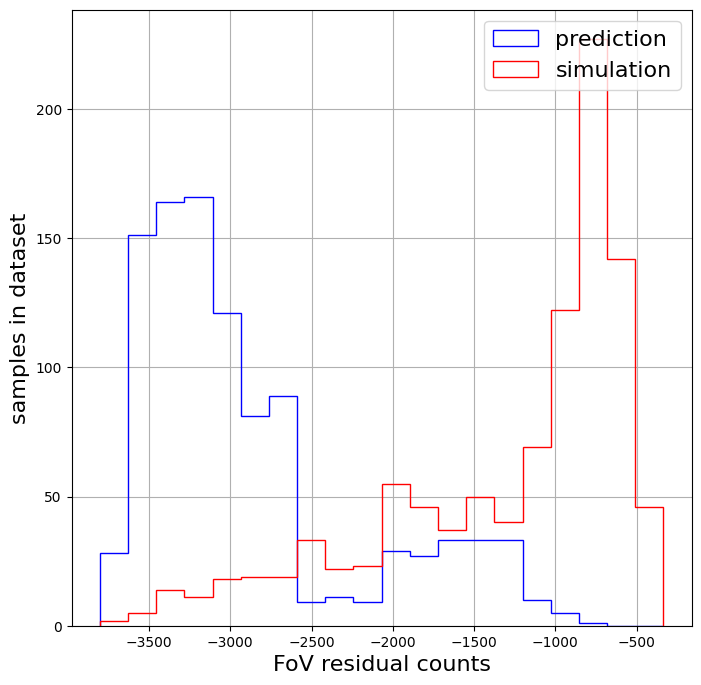

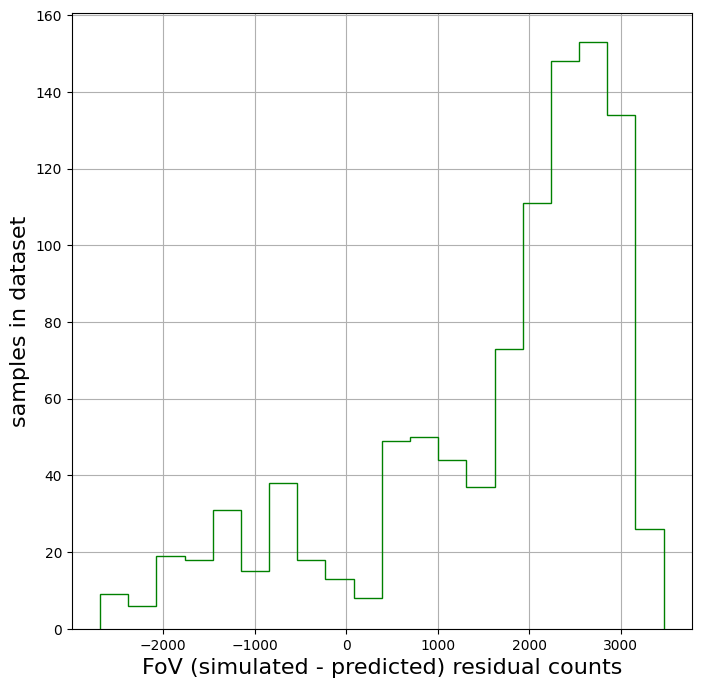

In [67]:
colors = ['red', 'blue']

# residual hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_residual['STD'], sum_residual['CNN'])
#ax.set_title('residuals', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color=colors, label=['simulation', 'prediction'])
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('FoV residual counts', fontsize=fs)
ax.legend(fontsize=fs)
ax.grid()

fig.savefig(f'img/talk_rand_residuals_counts.png')
plt.show()

# diff residual hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = sum_original_and_diff['DIFF']
#ax.set_title('residuals', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color='g')
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('FoV (simulated - predicted) residual counts', fontsize=fs)
ax.grid()

fig.savefig(f'img/talk_rand_residuals_counts_diff.png')
plt.show()

In [68]:
from astroai.tools.utils import create_circular_mask
from astropy.coordinates import SkyCoord

sum_on_region = {'STD': [], 'CNN': [], 'DIFF': []}

s = len(train_noisy)
for std, cnn in zip(test_clean, predictions):
    s += 1 
    row = infodata[infodata['seed']==s]
    # sky coordinates
    source_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    point_deg = {'ra': row['point_ra'].values[0], 'dec': row['point_dec'].values[0]}
    # pixel coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)
    x, y = w.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0], 
                                                   unit='deg', frame='icrs'))
    # ON counts with STD cleaning
    h, w = std.shape[:2]
    mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
    masked_std = std.copy()
    masked_std[~mask] = 0

    # ON counts with CNN cleaning
    h, w = cnn.shape[:2]
    mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
    masked_cnn = cnn.copy()
    masked_cnn[~mask] = 0
    
    sum_on_region['STD'].append(np.sum(masked_std))
    sum_on_region['CNN'].append(np.sum(masked_cnn))
    sum_on_region['DIFF'].append(np.sum(masked_std - masked_cnn))

sum_on_region.keys()

dict_keys(['STD', 'CNN', 'DIFF'])

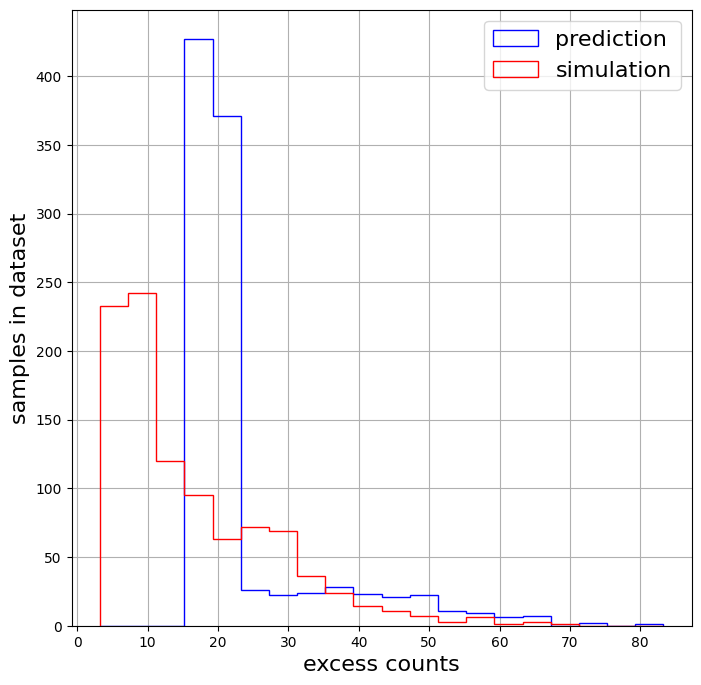

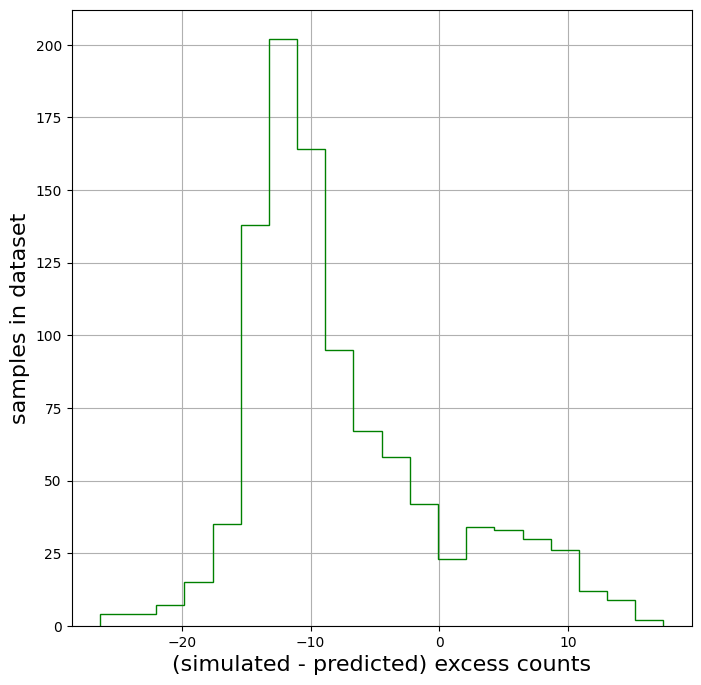

In [69]:
colors = ['red', 'blue'] 

# cumulative counts hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_on_region['STD'], sum_on_region['CNN']) 
#ax.set_title('residuals', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color=colors, label=['simulation', 'prediction'])
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('excess counts', fontsize=fs)
ax.legend(fontsize=fs)
ax.grid()

fig.savefig(f'img/talk_rand_on_counts.png')
plt.show()

# diff on counts hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = sum_on_region['DIFF']
#ax.set_title('residuals', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color='g')
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('(simulated - predicted) excess counts', fontsize=fs)
ax.grid()

fig.savefig(f'img/talk_rand_on_counts_diff.png')
plt.show()

# z20 IRF

In [1]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# data
zenith = 'z20'  # 'random'
table = 'cleaner_5sgm_exp30m_z20.pickle'
path = f'/home/dipiano/E4/irf_{zenith}/crab/'
dataset = join(path, table)

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
    gammatable = join(path, table.replace('.pickle', '_gammapy.txt'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))
    gammatable = join(path, table.replace('.npy', '_gammapy.txt'))
    
print(f"Classes: {ds.keys()}\n")
print(f"NOISY dataset size: {len(ds['DS1'])}")
print(f"CLEAN dataset size: {len(ds['DS2'])}")

ds['DS1'][0].shape, ds['DS2'][0].shape

Classes: dict_keys(['DS1', 'DS2', 'normalisation'])

NOISY dataset size: 20000
CLEAN dataset size: 20000


((200, 200), (200, 200))

In [2]:
from astroai.tools.utils import split_noisy_dataset

train_noisy, train_clean, test_noisy, test_clean = split_noisy_dataset(ds, split=80, reshape=True, binning=200)

print(f"Train clean: {train_clean.shape}")
print(f"Train noisy: {train_noisy.shape}")
print(f"\nTest clean: {test_clean.shape}")
print(f"Test labenoicyls: {test_noisy.shape}")

Train clean: (16000, 200, 200, 1)
Train noisy: (16000, 200, 200, 1)

Test clean: (4000, 200, 200, 1)
Test labenoicyls: (4000, 200, 200, 1)


In [3]:
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
infodata.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
14000,crab_00001,1,0,100,100,316.641513,12.589385,316.529421,12.904256,0.333312,North_z20_S_0.5h_LST,2.5,6.472037
14001,crab_00002,2,0,100,100,16.841739,78.034907,18.877416,77.993683,0.424728,North_z20_0.5h_LST,2.5,6.277098
14002,crab_00003,3,0,100,100,340.483309,-17.472847,340.130408,-17.623667,0.368734,North_z20_S_0.5h_LST,2.5,6.194221
14003,crab_00004,4,0,100,100,344.849066,86.535858,329.619289,84.942323,1.941093,North_z20_N_0.5h_LST,2.5,6.153547
14004,crab_00005,5,0,100,100,214.863376,34.357314,216.119150,33.122741,1.616953,North_z20_N_0.5h_LST,2.5,6.129901


In [4]:
import tensorflow as tf

savename = 'cleaner_5sgm_filter12_z20' 
model = tf.keras.models.load_model(f'../models/cnn_cleaner/{savename}.keras')
model.summary()

2024-04-09 17:49:00.680534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 17:49:03.031797: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-09 17:49:03.031876: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-09 17:49:13.246404: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 12)      60        
                                                                 
 average_pooling2d (AverageP  (None, 100, 100, 12)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 12)      588       
                                                                 
 average_pooling2d_1 (Averag  (None, 50, 50, 12)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 12)        588   

In [5]:
predictions = model.predict(test_noisy)

125/125 [==============================] - 5s 35ms/step


In [6]:
loss = model.evaluate(test_noisy, test_clean, verbose=2)

history = np.load(f'../models/cnn_cleaner/{savename}_history.npy', allow_pickle='TRUE').item()
history.keys()

125/125 - 5s - loss: 0.4194 - 5s/epoch - 38ms/step


dict_keys(['loss', 'val_loss'])

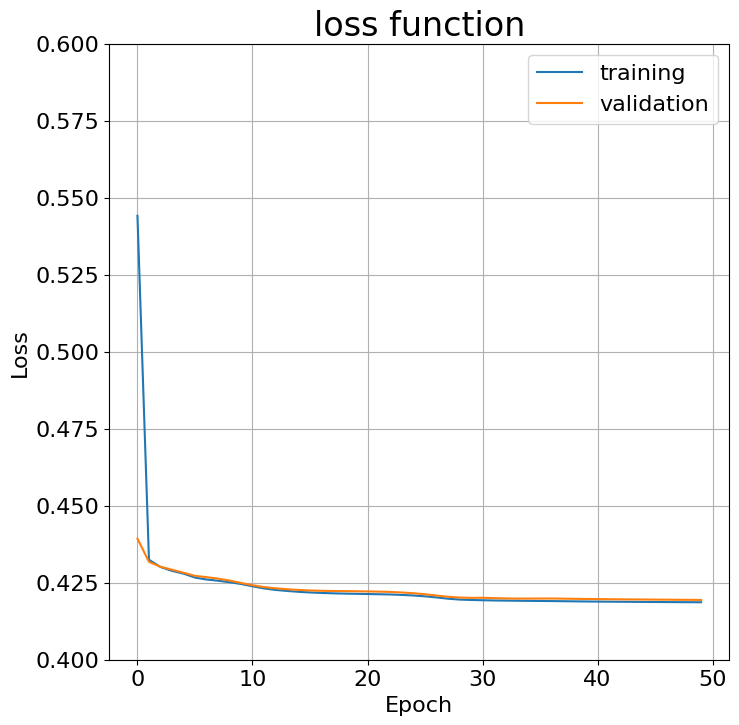

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)
ax.plot(history['loss'], label='training')
ax.plot(history['val_loss'], label = 'validation')
ax.set_xlabel('Epoch', fontsize=fs)
ax.set_ylabel('Loss', fontsize=fs)
ax.set_title('loss function', fontsize=fs*1.5)
ax.set_ylim([0.40,0.60])
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/talk_z20_loss.png')

In [11]:
residuals_z20 = {'STD': [], 'CNN': []}
for noisy, clean, pred in zip(test_noisy, test_clean, predictions):
    residuals_z20['STD'].append(noisy - clean)
    residuals_z20['CNN'].append(noisy - pred)
    
sum_residual_z20 = {'STD': [], 'CNN': []}
for std, cnn in zip(residuals_z20['STD'], residuals_z20['CNN']):
    sum_residual_z20['STD'].append(np.sum(std))
    sum_residual_z20['CNN'].append(np.sum(cnn))

sum_cleaned_z20 = {'STD': [], 'CNN': []}
for std, cnn in zip(test_clean, predictions):
    sum_cleaned_z20['STD'].append(np.sum(std))
    sum_cleaned_z20['CNN'].append(np.sum(cnn))
    
sum_original_and_diff_z20 = {'NOISY': [], 'DIFF': []}
for orig, std, cnn in zip(test_noisy, residuals_z20['STD'], residuals_z20['CNN']):
    sum_original_and_diff_z20['NOISY'].append(np.sum(orig))
    sum_original_and_diff_z20['DIFF'].append(np.sum(std - cnn))

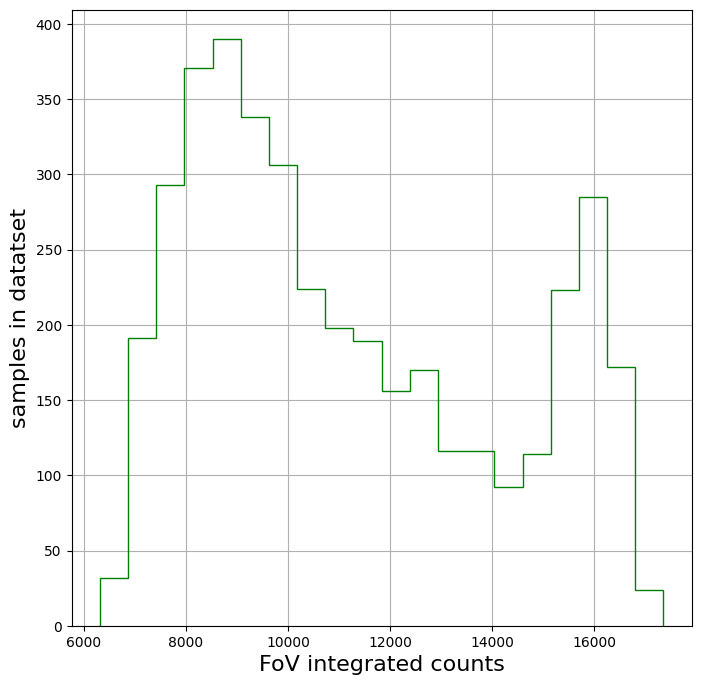

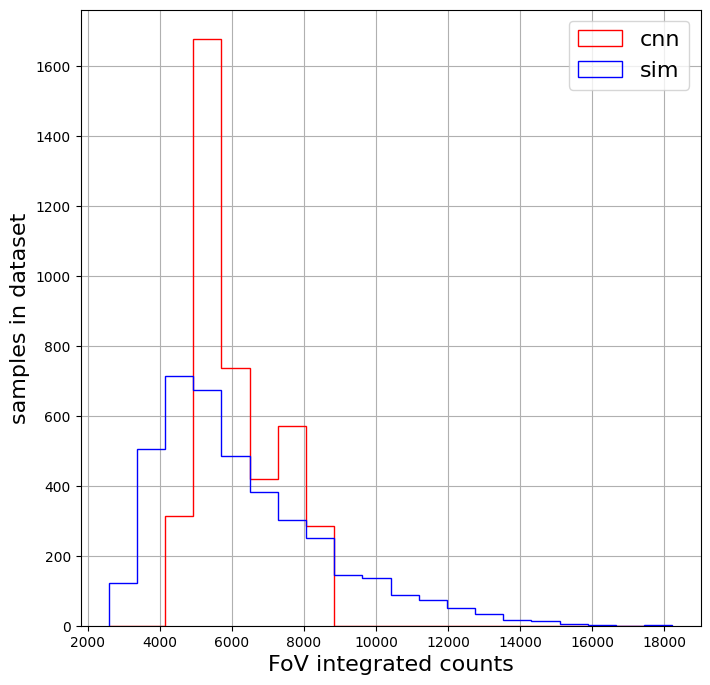

In [22]:
colors = ['blue', 'red']

# original hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = sum_original_and_diff_z20['NOISY']
#ax.set_title('simulations (noisy)', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color='green')
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in datatset', fontsize=fs)
ax.set_xlabel('FoV integrated counts', fontsize=fs)
ax.grid() 
fig.savefig(f'img/talk_z20_noisy_counts.png')
plt.show()

# cumulative counts hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_cleaned_z20['STD'], sum_cleaned_z20['CNN'])
#ax.set_title('simulations vs predictions (clean)', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color=colors, label=['sim', 'cnn'])
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('FoV integrated counts', fontsize=fs)
ax.legend(fontsize=fs)
ax.grid()

fig.savefig(f'img/talk_z20_clean_counts.png')
plt.show()

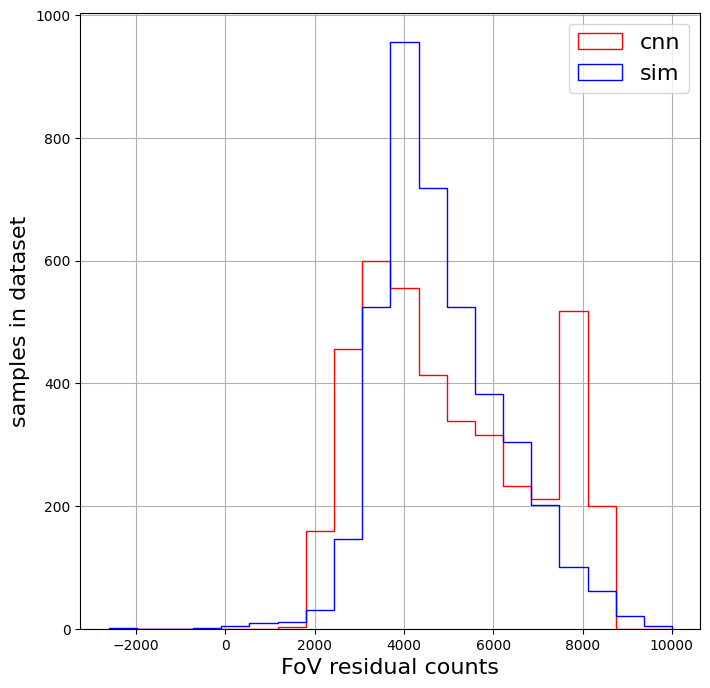

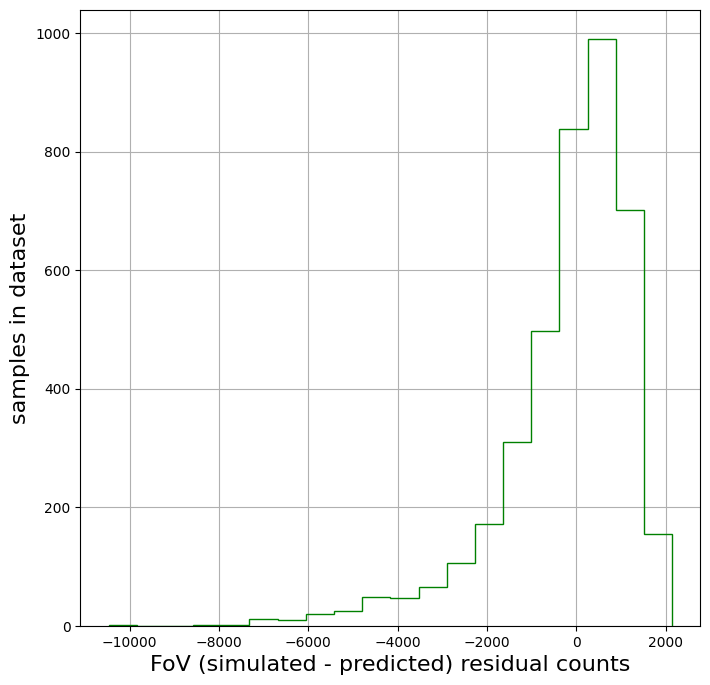

In [23]:
colors = ['blue', 'red']

# residual hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_residual_z20['STD'], sum_residual_z20['CNN'])
#ax.set_title('residuals', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color=colors, label=['sim', 'cnn'])
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('FoV residual counts', fontsize=fs)
ax.legend(fontsize=fs)
ax.grid()

fig.savefig(f'img/talk_z20_residuals_counts.png')
plt.show()

# residual diff hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = sum_original_and_diff_z20['DIFF']
#ax.set_title('residuals', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color='g')
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('FoV (simulated - predicted) residual counts', fontsize=fs)
ax.grid()

fig.savefig(f'img/talk_z20_residuals_counts_diff.png')
plt.show()

In [15]:
from astroai.tools.utils import create_circular_mask
from astropy.coordinates import SkyCoord

sum_on_region_z20 = {'STD': [], 'CNN': [], 'DIFF': []}

s = len(train_noisy)
for std, cnn in zip(test_clean, predictions):
    s += 1 
    row = infodata[infodata['seed']==s]
    # sky coordinates
    source_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    point_deg = {'ra': row['point_ra'].values[0], 'dec': row['point_dec'].values[0]}
    # pixel coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)
    x, y = w.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0], 
                                                   unit='deg', frame='icrs'))
    # ON counts with STD cleaning
    h, w = std.shape[:2]
    mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
    masked_std = std.copy()
    masked_std[~mask] = 0

    # ON counts with CNN cleaning
    h, w = cnn.shape[:2]
    mask = create_circular_mask(h, w, center=(y, x), radius=radius_pix)
    masked_cnn = cnn.copy()
    masked_cnn[~mask] = 0
    
    sum_on_region_z20['STD'].append(np.sum(masked_std))
    sum_on_region_z20['CNN'].append(np.sum(masked_cnn))
    sum_on_region_z20['DIFF'].append(np.sum(masked_std - masked_cnn))

sum_on_region_z20.keys()

dict_keys(['STD', 'CNN', 'DIFF'])

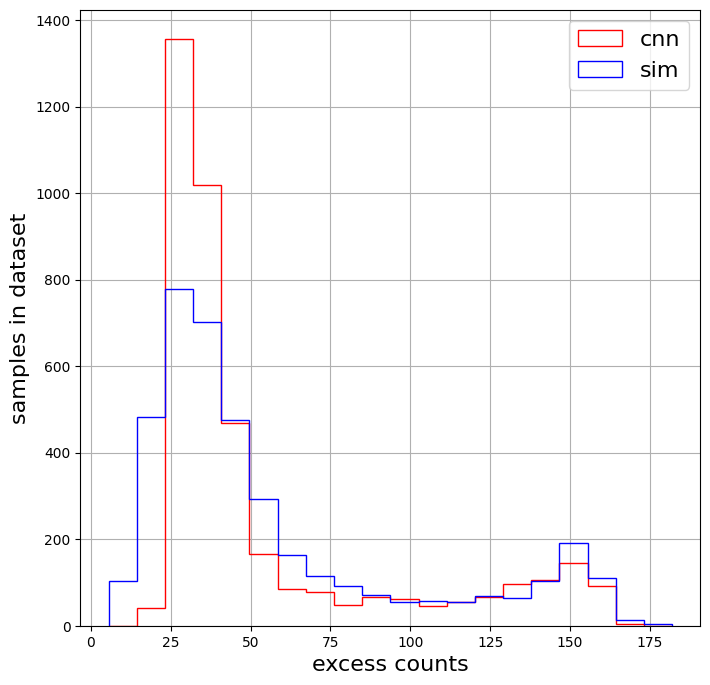

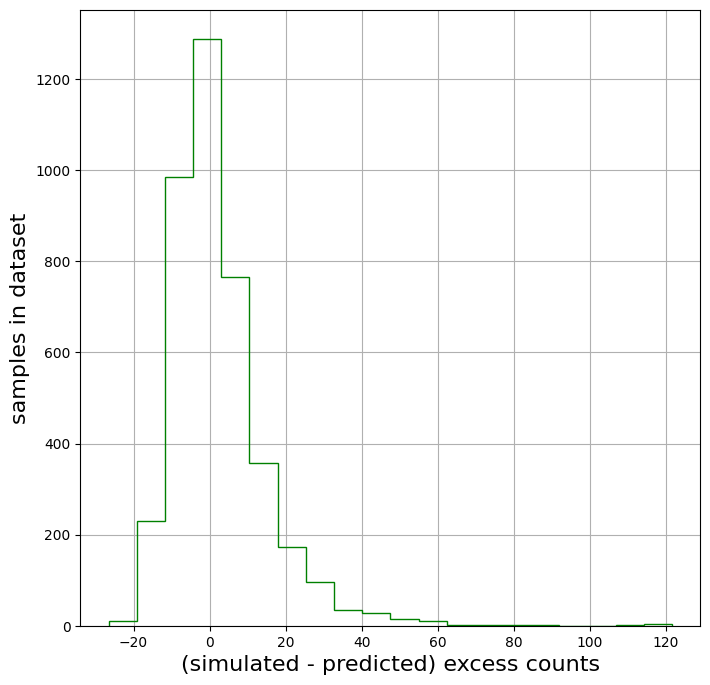

In [24]:
colors = ['blue', 'red'] 

# cumulative on counts hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_on_region_z20['STD'], sum_on_region_z20['CNN']) 
#ax.set_title('residuals', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color=colors, label=['sim', 'cnn'])
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('excess counts', fontsize=fs)
ax.legend(fontsize=fs)
ax.grid()

fig.savefig(f'img/talk_z20_on_counts.png')
plt.show()

# diff on counts hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = sum_on_region_z20['DIFF']
#ax.set_title('residuals', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color='g')
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('(simulated - predicted) excess counts', fontsize=fs)
ax.grid()

fig.savefig(f'img/talk_z20_on_counts_diff.png')
plt.show()

# Comparison

In [21]:
len(sum_original_and_diff['DIFF']), len(sum_original_and_diff_z20['DIFF'][:1000])

NameError: name 'sum_original_and_diff' is not defined

In [ ]:
colors = ['red', 'blue']

# residual diff hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_original_and_diff['DIFF'], sum_original_and_diff_z20['DIFF'][:1000])
#ax.set_title('residuals', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color=colors, label=['random IRF', 'z20 IRF'])
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('FoV (simulated - predicted) residual counts', fontsize=fs)
ax.legend(fontsize=fs)
ax.grid()

fig.savefig(f'img/talk_compare_residuals_counts_diff.png')
plt.show()

# diff on counts hist
fig = plt.figure(figsize=histsize)
ax = fig.add_subplot(111)

data = (sum_on_region['DIFF'], sum_on_region_z20['DIFF'][:1000])
#ax.set_title('residuals', fontsize=fs*1.5)
ax.hist(data, 20, density=False, histtype='step', color=colors, label=['random IRF', 'z20 IRF'])
#ax.tick_params(axis='both', labelsize=fs/2)
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('(simulated - predicted) excess counts', fontsize=fs)
ax.legend(fontsize=fs)
ax.grid()

fig.savefig(f'img/talk_compare_on_counts_diff.png')
plt.show()